In [3]:
from PIL import Image
from ipywidgets import interact,interactive,interact_manual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math

# 5109050014 施振勛 HW1 SVD

# 圖片處理與轉換

![Alt text](./images/svd/gray.png)
![Alt text](./images/svd/rgb.png)

左圖 : 彩色照片(橫)) 1 pixel > RGB 三個值 : [150 159 128]
Size : 1281600  = 534 x 800 x 3 

中圖 : 灰階照片 1 pixel > 灰階值 : 152
Size : 427200  = 534 x 800 

右圖 : 彩色照片(直) 1 pixel > RGB 三個值 : [175 164 118]
Size : 1281600  = 800 x 534 x 3 



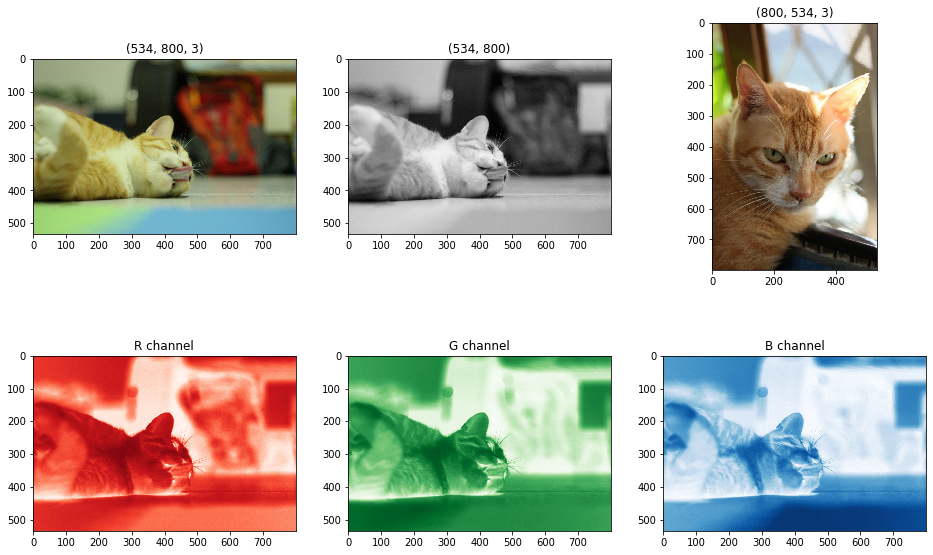

In [4]:
# 讀出一張RGB圖片(橫)

img_cat = Image.open("./images/svd/fatTiger.jpg", "r")

# 將RGB圖片轉為矩陣表示

cat = np.array(img_cat)

# 將RGB圖片轉為灰階圖片

img_to_gray = Image.open("./images/svd/fatTiger.jpg").convert("L")
cat_gray = np.array(img_to_gray)
img_gray = Image.fromarray(cat_gray).save("./images/svd/fatTiger_gr.jpg")

# 讀出一張RGB圖片(直)

img_cat_ver = Image.open("./images/svd/fatTiger_ver.jpg", "r")
cat_ver = np.array(img_cat_ver)

# 繪圖

plt.figure(figsize=(16 ,10))
plt.subplot(2,3,1)
plt.title(cat.shape)
plt.imshow(cat)
plt.subplot(2,3,2)
plt.title(cat_gray.shape)
plt.imshow(cat_gray, cmap="gray")
plt.subplot(2,3,3)
plt.title(cat_ver.shape)
plt.imshow(cat_ver)
plt.subplot(2,3,4)
plt.title("R channel")
plt.imshow(cat[:,:,0], cmap="Reds")
plt.subplot(2,3,5)
plt.title("G channel")
plt.imshow(cat[:,:,1], cmap="Greens")
plt.subplot(2,3,6)
plt.title("B channel")
plt.imshow(cat[:,:,2], cmap="Blues")

# 顯示資訊

print("左圖 : 彩色照片(橫)) 1 pixel > RGB 三個值 :", cat[0][0])
print("Size :", cat.size, " =", cat.shape[0], "x", cat.shape[1], "x", cat.shape[2], "\n")
print("中圖 : 灰階照片 1 pixel > 灰階值 :", cat_gray[0][0])
print("Size :", cat_gray.size, " =", cat_gray.shape[0], "x", cat_gray.shape[1], "\n")
print("右圖 : 彩色照片(直) 1 pixel > RGB 三個值 :", cat_ver[0][0])
print("Size :", cat_ver.size, " =", cat_ver.shape[0], "x", cat_ver.shape[1], "x", cat_ver.shape[2], "\n")

## Singular Value Decomposition (SVD) 概念

一個圖形矩陣，我們總可以將它分解爲以下形式，通過選取不同個數的 S(Σ) 中的奇異值，就可以實現圖像的壓縮。

![Alt text](./images/svd/svd.png)

## If the dimensions of A are m x n:

### U is an m x m matrix of Left Singular Vectors

### S is an m x n rectangular diagonal matrix of Singular Values arranged in decreasing order

### V is an n x n matrix of Right Singular Vectors

![Alt text](./images/svd/svd2.png)

![Alt text](./images/svd/svd3.png)

# 2-norm

In [5]:
# 2-norm

def norm2 (a, ak):
    return np.linalg.norm(a-ak, 2)

# mse 均方誤差

In [6]:
# mse 均方誤差

def mse (a, ak):
    m = np.mean((a/1.0 - ak/1.0) ** 2)
    return m

# Singular Value Decomposition (SVD)

In [7]:

# Singular Value Decomposition (SVD)

def svd_restore(image, k, rgb):

    # 對圖形矩陣做 SVD 分解 : u > mxm, sigma > m, v > mxn
    u, sigma, v = np.linalg.svd(image, full_matrices=False)

    # 避免 K 值超出 sigma > m 長度
    k = min(len(sigma)-1, k) 

    # 依照 k 值，得到新的圖形矩陣
    Ak  = np.dot(u[:,:k], np.dot(np.diag(sigma[:k]), v[:k,:]))

    # 計算原圖矩陣與新圖矩陣的 2-norm
    norm = norm2(image, Ak)

    # 計算原圖矩陣與新圖矩陣的 mse
    m = mse(image, Ak)

    # value 小於 0 > 改 0
    Ak[Ak < 0] = 0     
    
    # value 大於 255 > 改 255
    Ak[Ak > 255] = 255

    # 算出來為float，四捨五入取整數，轉型為圖片所需的 uint8
    Ak = np.rint(Ak).astype('uint8')

    return Ak, sigma, norm, sigma[k], m

## PSNR - 峰值訊噪比

![Alt text](./images/svd/PSNR.png)

In [8]:
# PSNR - 峰值訊噪比

def psnr(originalImg, sampleImg):

   mse = np.mean((originalImg/1.0 - sampleImg/1.0) ** 2 )
   
   if mse < 1.0e-10:
      return 100
   
   return 10 * math.log10(255.0**2/mse)

## compression Ratio 資料壓縮比  save space 節省空間比率

![Alt text](./images/svd/CR_SS.png)

In [9]:
# CR - compression Ratio 資料壓縮比

def cr(originalSize, sampleSize):
   return (originalSize/sampleSize)

# ss - save space 節省空間比率

def ss(originalSize, sampleSize):
   return (1-sampleSize/originalSize)*100

In [43]:
# 詳細資料圖表

def showTable(rangeArrK, info, fileName):

   table = np.zeros((15, 9))

   table[:,0] = rangeArrK.T
   table[:,1] = info[:,0]
   table[:,2] = info[:,1]
   table[:,7] = info[:,2]

   originalImage = cv2.imread("./images/svd/" + fileName + ".jpg")
   originalImageSize = round(os.stat("./images/svd/" + fileName + ".jpg").st_size/1024, 2)

   i = 0

   for item in rangeArrK:
      table[i,3] = originalImageSize
      table[i,4] = round(os.stat("./images/svd/svd_" + fileName + "_" + str(item) + ".jpg").st_size/1024, 2)
      svdImg = cv2.imread("./images/svd/svd_" + fileName + "_" + str(item) + ".jpg")
      table[i,5] = cr(originalImageSize, table[i,4])
      table[i,6] = ss(originalImageSize, table[i,4])
      table[i,8] = psnr(originalImage, svdImg)
      i += 1

   return table

# k值-正相關 SS MSE-負相關 SIZE PSNR

def showLinear(table, resize):
   plt.figure(figsize=(24,8),dpi=50,linewidth = 2)
   plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
   plt.xticks(fontsize=20)
   plt.yticks(fontsize=20)
   plt.xlabel("k值", fontsize=30, labelpad = 15)
   plt.legend(loc = "best", fontsize=20)
   plt.subplot(1,2,1)
   plt.plot(table[:,0], table[:,6],'s-',color = 'red', label="SS")
   plt.plot(table[:,0], table[:,7]/resize,'s-',color = 'skyblue', label="MSE/"+str(resize))
   plt.subplot(1,2,2)
   plt.plot(table[:,0], table[:,4],'s-',color = 'green', label="SIZE")
   plt.plot(table[:,0], table[:,8],'s-',color = 'blue', label="PSNR")
   plt.show()

# 可動態調整k值-灰階

def compress_show_gray_images(k):
    image = cat_gray
    original_shape = image.shape
    reconst_img, sigma, norm, sigmak1, m = svd_restore(image, k, "灰階")
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(reconst_img,cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()

# 可動態調整k值-彩色-resharp

def compress_show_color_images_reshape(k):
    image = cat
    original_shape = image.shape
    image_reshaped = image.reshape((original_shape[0],original_shape[1]*3))
    image_reconst, sigma, norm, sigmak1, m = svd_restore(image_reshaped, k, "灰階")
    image_reconst = image_reconst.reshape(original_shape)
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(image_reconst,cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()

# 可動態調整k值-彩色-layer

def compress_show_color_images_layer(k):
    image = cat_ver
    original_shape = image.shape
    image_reconst = np.zeros(original_shape)
    R, sigmaR, norm, sigmak1, m = svd_restore(image[:, :, 0], k, "R")
    G, sigmaG, norm, sigmak1, m = svd_restore(image[:, :, 1], k, "G")
    B, sigmaB, norm, sigmak1, m = svd_restore(image[:, :, 2], k, "B")
    sigma = (sigmaR+sigmaG+sigmaB)/3
    image_reconst = np.dstack((R, G, B))
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(image_reconst)
    axes[1].axis('off')
    fig.tight_layout()

# 使用的圖為 534x800 所以 0 < K < 534 (0 ~ 533)

In [11]:
# K值範圍

rangeArrK = np.array([1, 5, 10, 15, 20, 30, 50, 80, 100, 150, 200, 300, 500, 700, 900])

# 需要呈現的統計特徵
feature_names = np.array(["K值", "2-norm", "sigma k+1", "原圖大小(Kb)", "圖片大小(Kb)", "資料壓縮比(CR)", "節省空間比率(SS)", "均方誤差(MSE)", "峰值訊噪比(PSNR)"])

# 依照不同K值對灰階圖片進行壓縮

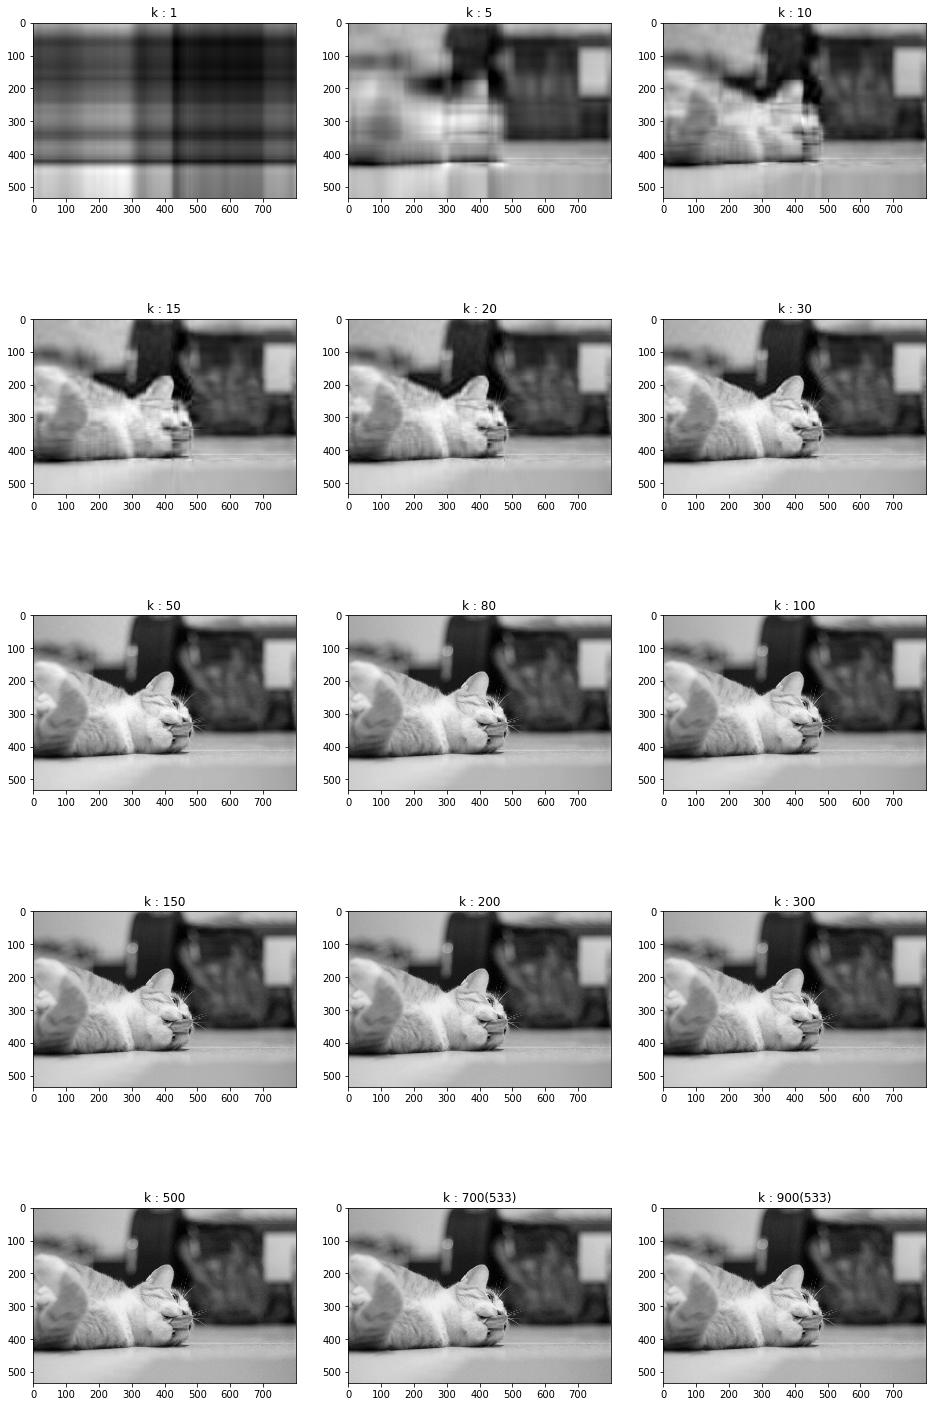

In [12]:
plt.figure(figsize=(16, 24))

p = 0

garyInfoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # 灰階圖的SVD分解
    
    G, sigma, norm, sigmak1, m = svd_restore(cat_gray, k, "灰階")

    garyInfoTempTable[p,0] = norm
    garyInfoTempTable[p,1] = sigmak1
    garyInfoTempTable[p,2] = m

    # 將壓縮過的圖片存在 svd 文件夾下

    Image.fromarray(G).save("images\\svd\\svd_fatTiger_gr_" + str(k) + ".jpg")

    # 透過 plt 顯示出來

    p += 1
    plt.subplot(5,3,p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)

    plt.title(title)
    plt.imshow(G, cmap="gray")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

No handles with labels found to put in legend.


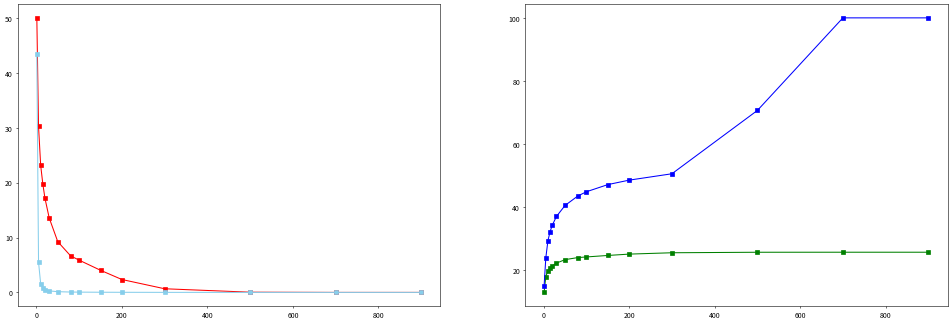

K值        2-norm     sigma k+1  原圖大小(Kb)  圖片大小(Kb)  資料壓縮比(CR)  \
0     1.0  19123.398832  19123.398832     25.54     12.77   2.000000   
1     5.0   6267.147744   6267.147744     25.54     17.82   1.433221   
2    10.0   2256.342994   2256.342994     25.54     19.63   1.301070   
3    15.0   1282.349621   1282.349621     25.54     20.49   1.246462   
4    20.0    870.162544    870.162544     25.54     21.16   1.206994   
5    30.0    526.789642    526.789642     25.54     22.08   1.156703   
6    50.0    281.513559    281.513559     25.54     23.18   1.101812   
7    80.0    152.537303    152.537303     25.54     23.84   1.071309   
8   100.0    114.311770    114.311770     25.54     24.04   1.062396   
9   150.0     76.434477     76.434477     25.54     24.51   1.042024   
10  200.0     61.038494     61.038494     25.54     24.94   1.024058   
11  300.0     41.914092     41.914092     25.54     25.37   1.006701   
12  500.0     14.453563     14.453563     25.54     25.53   1.000392   
13  700.0      9.196188      9.196188     25.54     25.54   1.000000   
14  900.0      9.196188      9.196188     25.54     25.54   1.000000   

    節省空間比率(SS)    均方誤差(MSE)  峰值訊噪比(PSNR)  
0    50.000000  2166.425113    14.775388  
1    30.227095   276.037230    23.744511  
2    23.140172    78.563030    29.252726  
3    19.772905    41.455641    32.075707  
4    17.149569    26.390049    34.079349  
5    13.547377    14.022375    36.920513  
6     9.240407     6.580023    40.398801  
7     6.656226     3.410500    43.411157  
8     5.873140     2.579995    44.751736  
9     4.032890     1.556694    47.019929  
10    2.349256     1.012150    48.444368  
11    0.665623     0.399213    50.467124  
12    0.039154     0.011581    70.589999  
13    0.000000     0.000198   100.000000  
14    0.000000     0.000198   100.000000

In [44]:
garyResult = showTable(rangeArrK, garyInfoTempTable, "fatTiger_gr")
showLinear(garyResult, 50)
pd.DataFrame(garyResult, columns=feature_names)

In [14]:
interact(compress_show_gray_images,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_gray_images(k)>

# 依照不同k值對彩色圖片進行壓縮 

## 1. Reshape method > 先將三維變二維，二維做完svd，再變回三維 > 彩色圖片(橫)

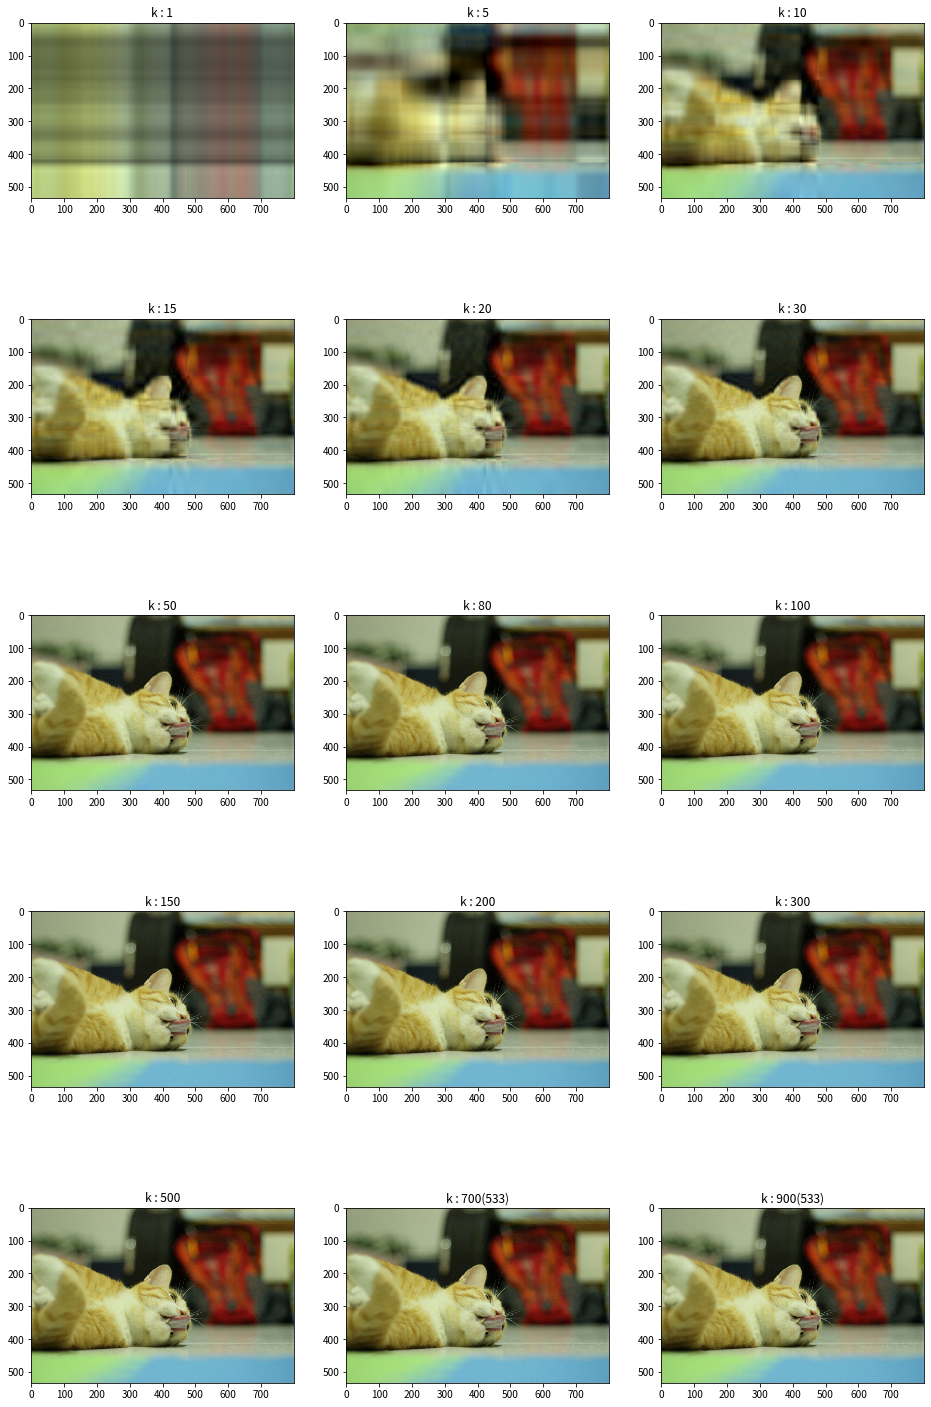

In [15]:
plt.figure(figsize=(16,24))

p = 0

infoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # Reshape method
    
    original_shape = cat.shape
    image_reshaped = cat.reshape((original_shape[0], original_shape[1] * original_shape[2]))
    image_reconst, sigma, norm, sigmak1, m = svd_restore(image_reshaped, k, "灰階")
    image_reconst = image_reconst.reshape(original_shape)

    infoTempTable[p,0] = norm
    infoTempTable[p,1] = sigmak1
    infoTempTable[p,2] = m

    # 將壓縮過的圖片存在 svd 文件夾下
    Image.fromarray(image_reconst).save("images\\svd\\svd_fatTiger_" + str(k) + ".jpg")

    # 透過 plt 顯示出來
    p += 1
    plt.subplot(5, 3, p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)

    plt.title(title)
    plt.imshow(image_reconst)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

No handles with labels found to put in legend.


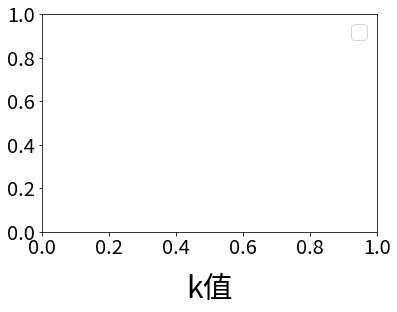

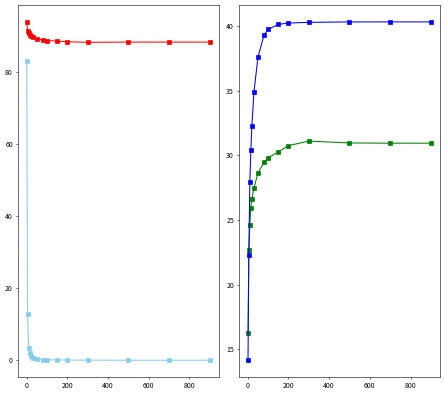

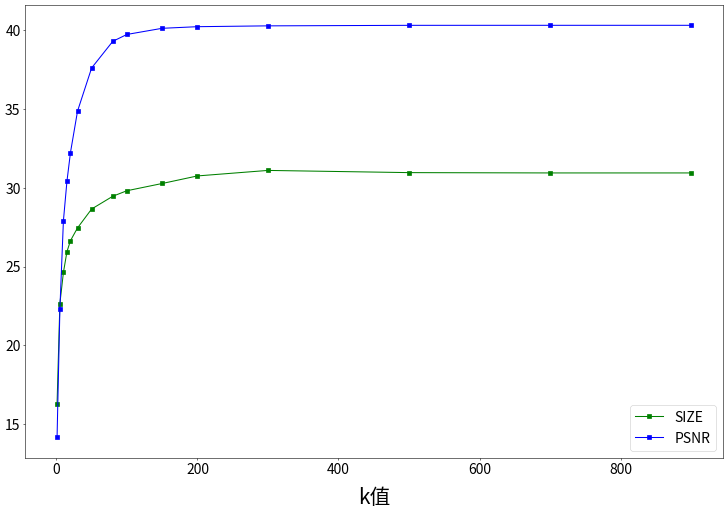

K值        2-norm     sigma k+1  原圖大小(Kb)  圖片大小(Kb)  資料壓縮比(CR)  \
0     1.0  32110.029015  32110.029015    262.29     16.29  16.101289   
1     5.0  12194.613296  12194.613296    262.29     22.65  11.580132   
2    10.0   4113.631551   4113.631551    262.29     24.62  10.653534   
3    15.0   2670.636297   2670.636297    262.29     25.94  10.111411   
4    20.0   1854.556762   1854.556762    262.29     26.64   9.845721   
5    30.0   1085.955280   1085.955280    262.29     27.45   9.555191   
6    50.0    585.559513    585.559513    262.29     28.65   9.154974   
7    80.0    314.449228    314.449228    262.29     29.46   8.903259   
8   100.0    239.257579    239.257579    262.29     29.81   8.798725   
9   150.0    161.619241    161.619241    262.29     30.27   8.665015   
10  200.0    127.004907    127.004907    262.29     30.75   8.529756   
11  300.0     88.151951     88.151951    262.29     31.10   8.433762   
12  500.0     37.938762     37.938762    262.29     30.96   8.471899   
13  700.0     28.213386     28.213386    262.29     30.94   8.477376   
14  900.0     28.213386     28.213386    262.29     30.94   8.477376   

    節省空間比率(SS)    均方誤差(MSE)  峰值訊噪比(PSNR)  
0    93.789317  2490.496146    14.168936  
1    91.364520   388.192180    22.290984  
2    90.613443   105.487226    27.905332  
3    90.110183    58.743508    30.408219  
4    89.843303    38.098143    32.234745  
5    89.534485    20.118504    34.861905  
6    89.076976     9.576908    37.604100  
7    88.768157     5.061465    39.294600  
8    88.634717     3.866990    39.731096  
9    88.459339     2.360492    40.121280  
10   88.276335     1.554086    40.224089  
11   88.142895     0.663814    40.276681  
12   88.196271     0.030348    40.309616  
13   88.203896     0.000621    40.311071  
14   88.203896     0.000621    40.311071

In [17]:
rgbResult = showTable(rangeArrK, infoTempTable, "fatTiger")
showLinear(rgbResult, 30)
pd.DataFrame(rgbResult, columns=feature_names)

In [18]:
interact(compress_show_color_images_reshape,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_color_images_reshape(k)>

## 2. Layers method > 分別對二維的R圖、G圖、B圖各自做svd，再把三張圖合起來 > 彩色圖片(直)

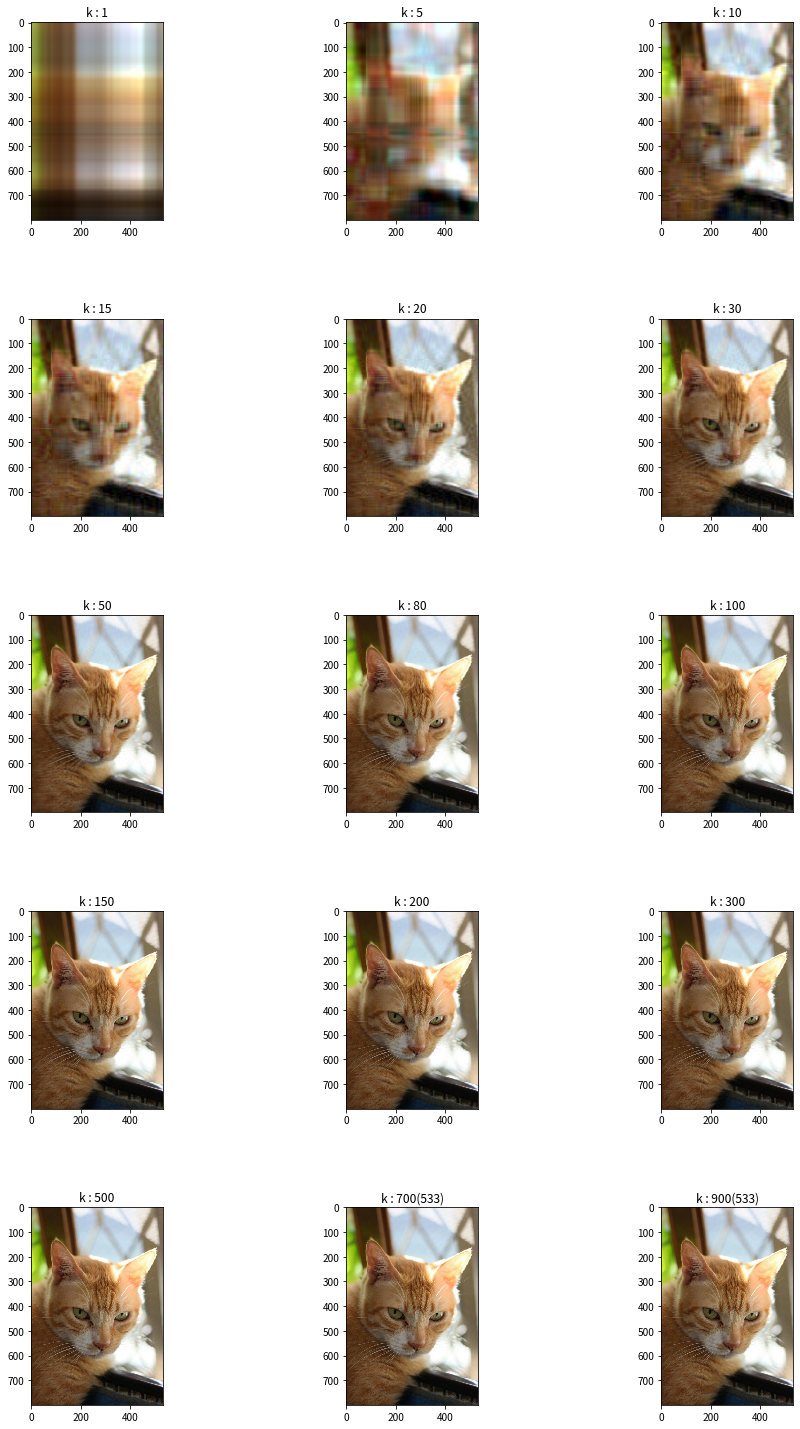

In [19]:
plt.figure(figsize=(16,24))

p = 0

verInfoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # R的SVD分解
    R, sigma, normR, sigmak1R, mR = svd_restore(cat_ver[:, :, 0], k, "R")

    # G的SVD分解  
    G, sigma, normG, sigmak1G, mG = svd_restore(cat_ver[:, :, 1], k, "G")

    # B的SVD分解     
    B, sigma, normB, sigmak1B, mB = svd_restore(cat_ver[:, :, 2], k, "B")

    verInfoTempTable[p,0] = (normR+normG+normB)/3
    verInfoTempTable[p,1] = (sigmak1R+sigmak1G+sigmak1B)/3
    verInfoTempTable[p,2] = (mR+mG+mB)/3

    # 壓縮後的 RGB 組合一張圖    
    I = np.dstack((R, G, B))

    # 將壓縮過的圖片存在 svd 文件夾下
    Image.fromarray(I).save("images\\svd\\svd_fatTiger_ver_" + str(k) + ".jpg")

    # 透過 plt 顯示出來
    p += 1
    plt.subplot(5,3,p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)
    
    plt.title(title)
    plt.imshow(I)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

No handles with labels found to put in legend.


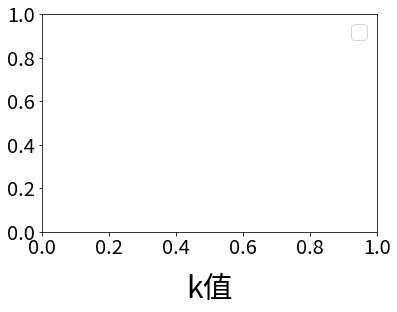

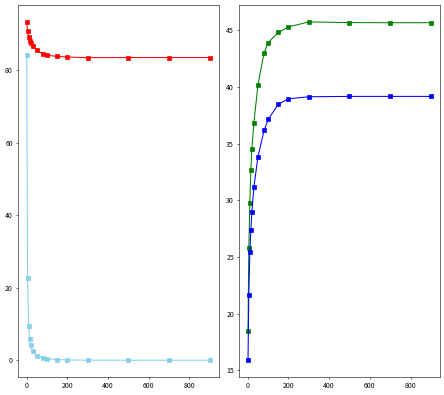

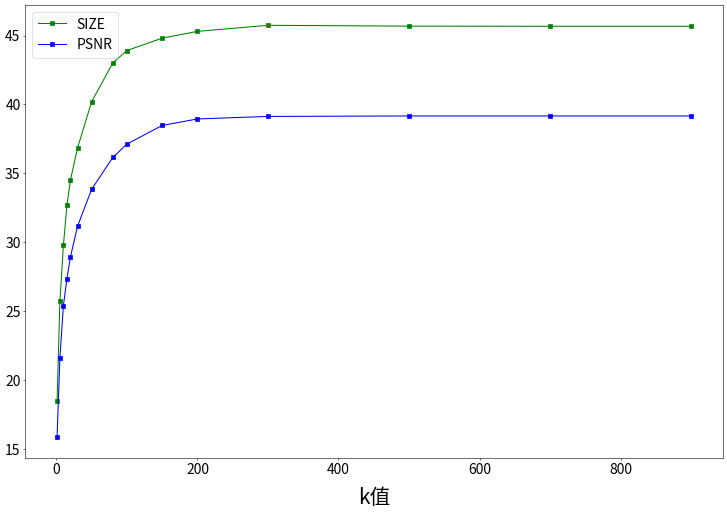

K值        2-norm     sigma k+1  原圖大小(Kb)  圖片大小(Kb)  資料壓縮比(CR)  \
0     1.0  15362.367948  15362.367948    276.77     18.48  14.976732   
1     5.0   6445.986307   6445.986307    276.77     25.74  10.752525   
2    10.0   2858.350802   2858.350802    276.77     29.79   9.290702   
3    15.0   2001.646001   2001.646001    276.77     32.69   8.466504   
4    20.0   1492.572659   1492.572659    276.77     34.52   8.017671   
5    30.0    928.737424    928.737424    276.77     36.84   7.512758   
6    50.0    537.034930    537.034930    276.77     40.20   6.884826   
7    80.0    328.786626    328.786626    276.77     43.01   6.435015   
8   100.0    252.421211    252.421211    276.77     43.91   6.303120   
9   150.0    152.471119    152.471119    276.77     44.81   6.176523   
10  200.0    100.910147    100.910147    276.77     45.30   6.109713   
11  300.0     49.967432     49.967432    276.77     45.74   6.050940   
12  500.0     13.862846     13.862846    276.77     45.68   6.058888   
13  700.0      8.498601      8.498601    276.77     45.67   6.060215   
14  900.0      8.498601      8.498601    276.77     45.67   6.060215   

    節省空間比率(SS)    均方誤差(MSE)  峰值訊噪比(PSNR)  
0    93.322976  1684.264414    15.875998  
1    90.699859   456.381013    21.632293  
2    89.236550   188.545100    25.417296  
3    88.188749   119.730079    27.371050  
4    87.527550    82.755046    28.950825  
5    86.689309    48.868419    31.163515  
6    85.475304    24.875269    33.847752  
7    84.460021    12.207721    36.155952  
8    84.134841     8.286774    37.125906  
9    83.809661     3.566163    38.479024  
10   83.632619     1.723190    38.950164  
11   83.473642     0.458483    39.133345  
12   83.495321     0.010553    39.166378  
13   83.498934     0.000169    39.166342  
14   83.498934     0.000169    39.166342

In [20]:
verResult = showTable(rangeArrK, verInfoTempTable, "fatTiger_ver")
showLinear(verResult, 20)
pd.DataFrame(verResult, columns=feature_names)

In [22]:
interact(compress_show_color_images_layer,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_color_images_layer(k)>